In [1]:
%matplotlib inline
from CartPole import CartPole, remap_angle, _remap_angle, _loss, loss, move_cart, generate_data, plot_y_contour_as_difference_in_x, range_x_pair_finder, plot_prediction_vs_actual_over_time, project_x_using_model
import numpy as np
import matplotlib.pyplot as plt

# Task 2

In [2]:
plot_path = 'plots/Task2/'
index_to_variable = {0 : 'cart_location', 1 : 'cart_velocity', 2 : 'pole_angle', 3 : 'pole_velocity'}
no_samples = 20
x_range_for_index = {0 : np.linspace(-5,5,no_samples), 1 : np.linspace(-10,10,no_samples), 2 : np.linspace(-np.pi,np.pi,no_samples), 3 : np.linspace(-15,15,no_samples)}


In [3]:
def kernel(X, X_dash, sigma):

    if type(X) == list: X = np.array(X)
    if type(X_dash) == list: X_dash = np.array([X_dash])
    
    try:
        squared_numerator = np.array([(X[i]-X_dash[i])**2 if i != 2  else (np.sin((X[i]-X_dash[i])/2))**2 for i in range(4)])
    except:
        print(X, X_dash, '<------------ fix this')
    return np.exp(-np.sum(np.divide(squared_numerator, 2*np.square(sigma))))

In [4]:
def generate_K(X, M, sigma, kernel=kernel):
    if type(M) != list: M = np.array(M)
        
    for i,x_location in enumerate(X):
        K_row = np.array([kernel(x_location, RBF_x, sigma) for RBF_x in X[M]])
        try:
            KnM = np.vstack((KnM, K_row))
        except:
#             print('first row of K: {} <---------------------- this should only happen once'.format(K_row.shape))
            KnM = K_row
            
    return KnM

In [5]:
def train_alpha(x_train, y_train, no_RBC, sigma, kernel=kernel, lam=0.00001):
    
    M_vals = np.random.randint(0, high=n*train_proportion, size=no_RBC)
    X_i_vals = x_train[M_vals]
    KnM_ = generate_K(x_train, M_vals, sigma, kernel)
    KMM_ = generate_K(X_i_vals, [i for i in range(M_vals.size)], sigma, kernel)
    alpha = np.linalg.lstsq(np.matmul(KnM_.T, KnM_) + lam*KMM_, np.matmul(KnM_.T, y_train))[0]

#     alpha = np.linalg.lstsq(np.matmul(KnM_.T, KnM_), np.matmul(KnM_.T, y_train))[0]
#     alpha = np.matmul(np.linalg.pinv(KnM_), y_train).T
#     print('alpha.shape: {}'.format(alpha.shape))
    
    return alpha, X_i_vals

In [6]:
def predict(x_test, alpha, X_i_vals, sigma, kernel=kernel):
    
    KnM_test= [None, None]
    for X_i in X_i_vals:
        if x_test.size > 4:
            assert x_test.size % 4 == 0, 'x_test.size: ' + x_test.size
            KnM_test_row = np.array([kernel(X_i, x_test_, sigma=sigma) for x_test_ in x_test])
        elif x_test.size == 4:
            if x_test.ndim > 1: x_test = x_test[0]
            KnM_test_row = kernel(X_i, x_test, sigma=sigma)
        try:
            KnM_test = np.vstack((KnM_test, KnM_test_row))
        except:
            KnM_test = KnM_test_row
#     print('KnM_test.shape: {}'.format(KnM_test.shape))
    predictions = np.matmul(KnM_test.T, alpha)
#     print('predictions.shape: {}'.format(predictions.shape))
    
    return predictions

In [7]:
def display_RMSE(predictions, y_test):
    targets = y_test            
    return [np.sqrt(np.mean((predictions[:,j]-targets[:,j])**2)) for j in range(4)] 

## plot convergence of model for varying no. basis functions

In [8]:
n = 500
x,y = generate_data(n)
train_proportion = 0.8
x_train, y_train, x_test, y_test = x[:int(n*train_proportion)], y[:int(n*train_proportion)], x[int(n*train_proportion):], y[int(n*train_proportion):]
sigma = np.std(x_train, axis=0)
lam = 0.001
i_range = [10, 20, 40, 80, 160, 320]

# fig,axs = plt.subplots(2,2,figsize=(12,9))
# for n in [500, 1000, 2000, 4000]:
#     x,y = generate_data(n)
#     x_train, y_train, x_test, y_test = x[:int(n*train_proportion)], y[:int(n*train_proportion)], x[int(n*train_proportion):], y[int(n*train_proportion):]
#     sigma = np.std(x_train, axis=0)
    
#     RMSE = None
    
#     for i in i_range:
#         alpha, X_i_vals = train_alpha(x_train, y_train, i, sigma)
#         predictions = predict(x_test, alpha, X_i_vals, sigma)
#         RMSE_ = np.array(display_RMSE(predictions, y_test))
        
#         try:
#             RMSE = np.vstack((RMSE, RMSE_))
#         except:
#             RMSE = RMSE_
#     for j in range(4):
#         axs[int(round((j+1)/4,0)),j%2].plot(i_range, RMSE[:,j], label='N = {}'.format(str(n)))
#         axs[int(round((j+1)/4,0)),j%2].legend()
#         axs[int(round((j+1)/4,0)),j%2].set_title(index_to_variable[j])
#         axs[int(round((j+1)/4,0)),j%2].set_xlabel('no. basis functions')
#         axs[int(round((j+1)/4,0)),j%2].set_ylabel('RMSE')
# fig.tight_layout()
# plt.savefig(plot_path + 'convergence_of_non_linear_model')

## Plot model predictions vs actual values

In [9]:
n = 1000
x,y = generate_data(n)
train_proportion = 0.8
x_train, y_train, x_test, y_test = x[:int(n*train_proportion)], y[:int(n*train_proportion)], x[int(n*train_proportion):], y[int(n*train_proportion):]
sigma = np.std(x_train, axis=0)
lam = 0.001

alpha, X_i_vals = train_alpha(x_train, y_train, 160, sigma)
predictions = predict(x_test, alpha, X_i_vals, sigma)
# fig,axs = plt.subplots(2,2,figsize=(12,9))

# for j in range(4):
#     ul = max(max(predictions[:,j]), max(y_test[:,j]))
#     ll = min(min(predictions[:,j]), min(y_test[:,j]))
#     axs[int(round((j+1)/4,0)),j%2].scatter(predictions[:,j], y_test[:,j])
#     axs[int(round((j+1)/4,0)),j%2].plot([ll,ul],[ll,ul], color='g')
#     axs[int(round((j+1)/4,0)),j%2].set_title(index_to_variable[j])
#     axs[int(round((j+1)/4,0)),j%2].set_xlabel('prediction')
#     axs[int(round((j+1)/4,0)),j%2].set_ylabel('actual')
    
#     fig.tight_layout()
    
# plt.savefig(plot_path + 'prediction_accuracy')

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


## Plot contours for non linear model

In [10]:
# for index_pair in [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]:
#     plot_y_contour_as_difference_in_x(x[0], index_pair, range_x_pair_finder(index_pair, x_range_for_index), 
#                                       index_to_variable, dynamics='predicted', model=predict, alpha=alpha, 
#                                       X_i_vals=X_i_vals, sigma=sigma)
#     plt.savefig(plot_path+'contour_plot_predictions'+str(index_pair))
#     plt.close()

## Rollout with model prediction

1.0


C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


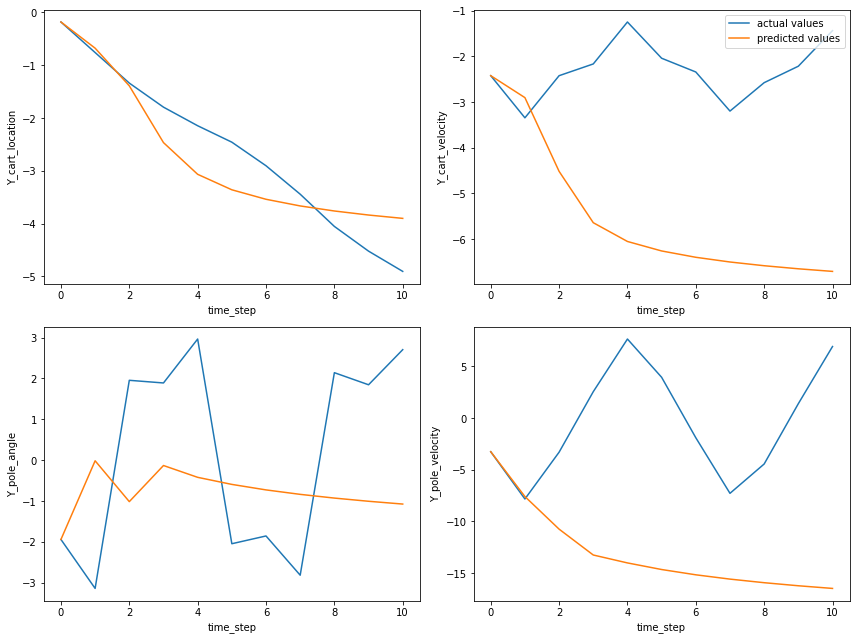

0.1


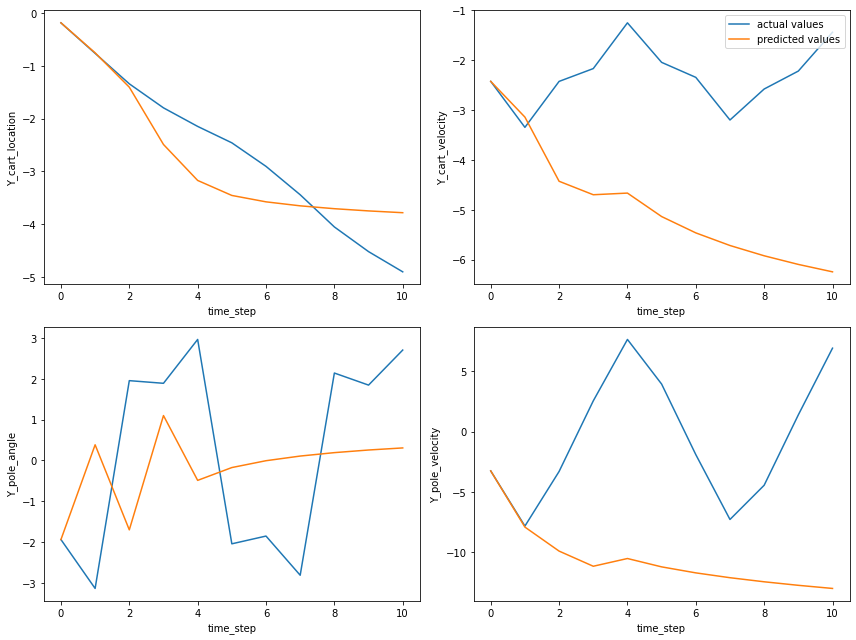

0.010000000000000002


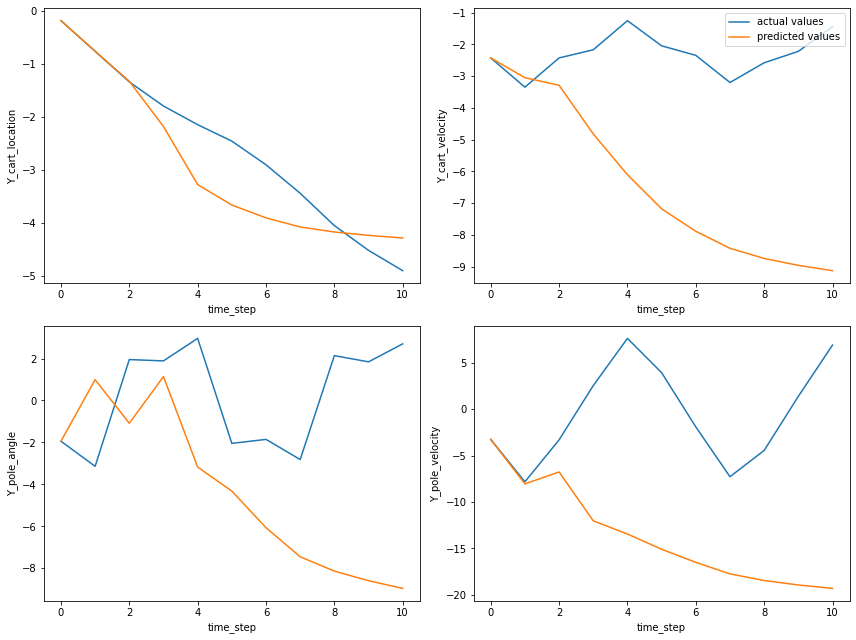

0.0010000000000000002


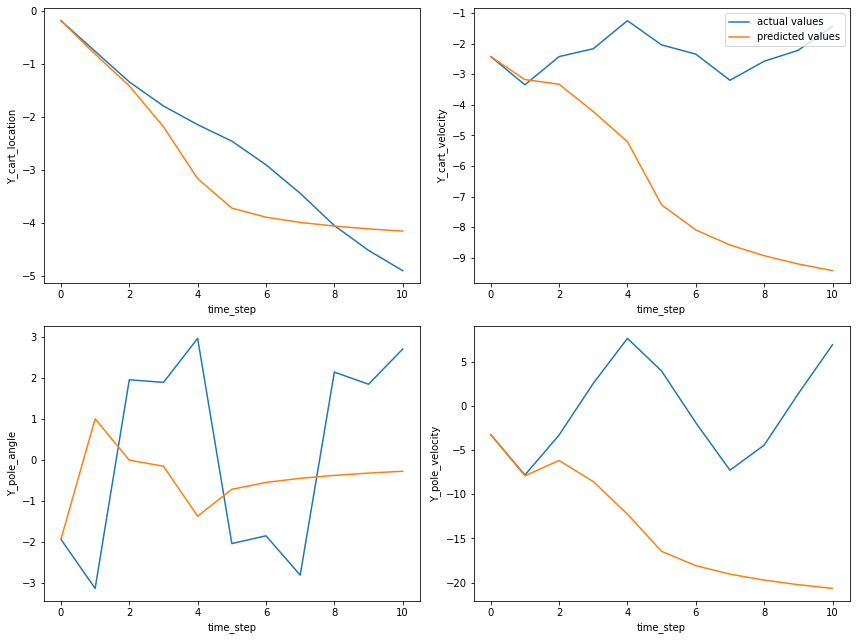

0.00010000000000000002


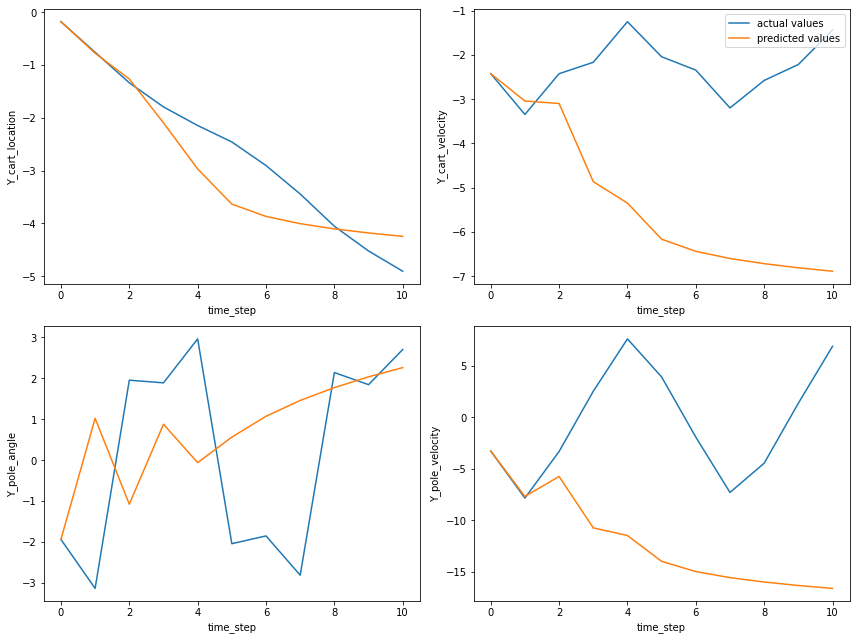

1.0000000000000003e-05


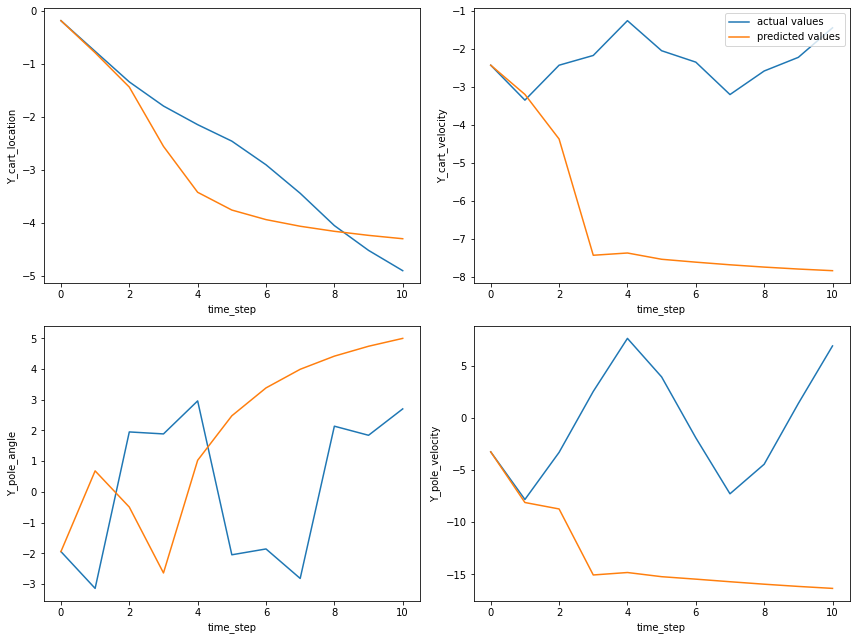

In [15]:
n = 2000
x,y = generate_data(n)
train_proportion = 0.8
x_train, y_train, x_test, y_test = x[:int(n*train_proportion)], y[:int(n*train_proportion)], x[int(n*train_proportion):], y[int(n*train_proportion):]
sigma = np.std(x_train, axis=0)

for lam in [0.1**i for i in range(6)]:
    print(lam)
    alpha, X_i_vals = train_alpha(x_train, y_train, 160, sigma, lam = lam)
    predictions = predict(x_test, alpha, X_i_vals, sigma)

    prediction_history, y_history = project_x_using_model(x[0], predict, steps=10, remap_angle=True, alpha=alpha, 
                                                           X_i_vals=X_i_vals, sigma=sigma)
    plot_prediction_vs_actual_over_time(prediction_history, y_history, title=None)
    plt.show()